In [1]:
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns

from arnie.free_energy import free_energy
from arnie.utils import write_constraints

Populating the interactive namespace from numpy and matplotlib


Replicating some of the analysis done in 

Becker, W. R., Jarmoskaite, I., Kappel, K., Vaidyanathan, P. P., Denny, S. K., Das, R., ... & Herschlag, D. (2019). _Quantitative high-throughput tests of ubiquitous RNA secondary structure prediction algorithms via RNA/protein binding._ BioRxiv, 571588.

https://www.biorxiv.org/content/10.1101/571588v1

In [28]:
#df = pd.read_csv("sample_PUM_array_data.txt",delimiter='\t',comment='#')
df = pd.read_excel("/Users/hwayment/das/PUM_analysis/jan21_redo_from_SI.xlsx")
df = df.dropna(subset=['ddG_25_exp'])
df['Sequence'] = [x.replace('T','U') for x in df['Sequence']]

#find PUM binding motif and write corresponding constraint
df['binding_constraint'] = [write_constraints(seq, motif=('UGUAUAUn','xxxxxxxx')) for seq in df['Sequence']]

#what do these look like?
print(df['Sequence'][1])
print(df['binding_constraint'][1])

UUUUAUUCCACCACCCCCUUGUAUAUAUUU
...................xxxxxxxx...


In [29]:
df.keys()

Index(['Sequence', 'PUM_site', 'dG_25C', 'dG_25C_constr', 'ddG_predfold',
       'ddG_25_exp', 'binding_constraint'],
      dtype='object')

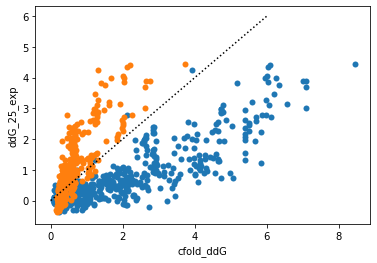

In [37]:
def plot_diag(): plot([0,6],[0,6],linestyle=':',c='k')

sns.scatterplot(x='ddG_predfold',y='ddG_25_exp', data=df.loc[df['PUM_site']=='wt'], linewidth=0)
sns.scatterplot(x='cfold_ddG',y='ddG_25_exp', data=df.loc[df['PUM_site']=='wt'], linewidth=0)

#sns.scatterplot(x='vienna_ddG',y='ddGpredfold_from_paper_25C',data=df,linewidth=0)
plot_diag()

In [49]:
#Create new dataframe values through a lambda function on rows:
df['dG_vienna_full_ensemble'] = df.apply(lambda row: 
                                         free_energy(row['Sequence'], package='vienna_2',T=25)
                                         , axis=1)

df['dG_vienna_PUM_site_constrained'] = df.apply(lambda row: 
                                        free_energy(row['Sequence'], package='vienna_2', constraint=row['binding_constraint'],T=25)
                                                , axis=1)

df['dG_cfold_full_ensemble'] = df.apply(lambda row: 
                                        free_energy(row['Sequence'], package='contrafold')
                                        , axis=1)

df['dG_cfold_PUM_site_constrained'] = df.apply(lambda row: 
                                               free_energy(row['Sequence'], package='contrafold', constraint=row['binding_constraint'])
                                               , axis=1)  

df['vienna_ddG'] = df['dG_vienna_PUM_site_constrained'] - df['dG_vienna_full_ensemble']
df['cfold_ddG'] = df['dG_cfold_PUM_site_constrained'] - df['dG_cfold_full_ensemble']

In [55]:
for cond in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    df['dG_efold_%s_full_ensemble' % cond] = df.apply(lambda row: 
                                            free_energy(row['Sequence'], package='contrafold',
                                                        param_file = '/Users/hwayment/das/eternafold_analysis/all_production_params/params_%s' % cond)
                                            , axis=1)

    df['dG_efold_%s_PUM_site_constrained' % cond] = df.apply(lambda row: 
                                                   free_energy(row['Sequence'], package='contrafold', constraint=row['binding_constraint'],
                                                        param_file = '/Users/hwayment/das/eternafold_analysis/all_production_params/params_%s' % cond)
                                                   , axis=1)  

    df['efold_%s_ddG' % cond] = df['dG_efold_%s_PUM_site_constrained' % cond] - df['dG_efold_%s_full_ensemble' % cond]

In [56]:
df.to_csv('jan21_PUM_efold_analysis.csv')

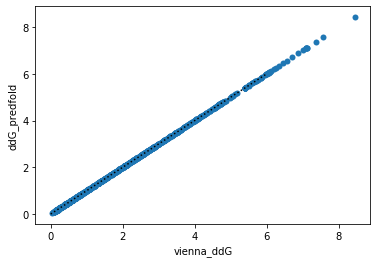

In [35]:
def plot_diag(): plot([0,6],[0,6],linestyle=':',c='k')

sns.scatterplot(x='vienna_ddG',y='ddG_predfold',data=df,linewidth=0)
plot_diag()


/Users/hwayment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


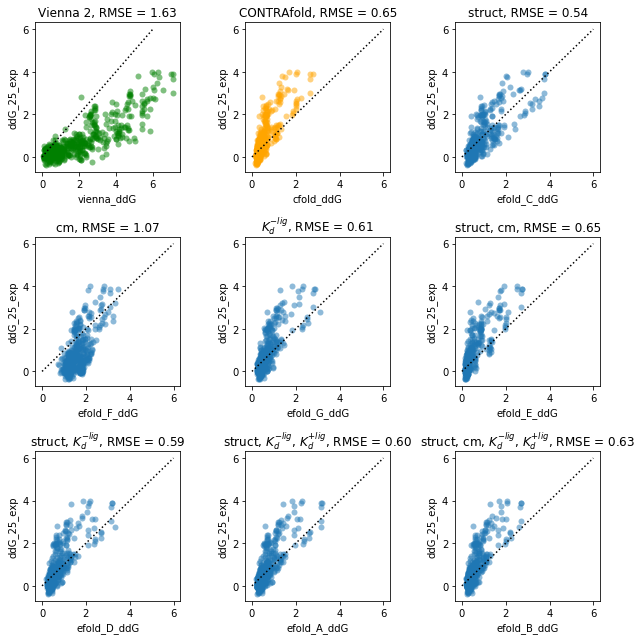

In [71]:
alpha=0.5
figure(figsize=(9,9))

def plot_diag(): plot([0,6],[0,6],linestyle=':',c='k')

tmp_df = df.loc[df['PUM_site']=='wt'][df['ddG_25_exp']<4]

cond_dct={'C': 'struct',
         'D': r'struct, $K_d^{-lig}$',
         'A': r'struct, $K_d^{-lig}$, $K_d^{+lig}$',
         'E': 'struct, cm',
         'F': 'cm',
         'G': r'$K_d^{-lig}$',
         'B': r'struct, cm, $K_d^{-lig}$, $K_d^{+lig}$'}

subplot(3,3,1)

title('Vienna 2, RMSE = %.2f' % np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['vienna_ddG']))))
sns.scatterplot(x='vienna_ddG',y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha,color='green')
plot_diag()

subplot(3,3,2)
title('CONTRAfold, RMSE = %.2f' % np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['cfold_ddG']))))
sns.scatterplot(x='cfold_ddG',y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha, color='orange')
plot_diag()

for i, cond in enumerate(['C', 'F', 'G','E',  'D', 'A', 'B']):
    subplot(3,3,i+3)

    title('%s, RMSE = %.2f' % (cond_dct[cond], np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['efold_%s_ddG' % cond])))))
    sns.scatterplot(x='efold_%s_ddG' % cond,y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha)
    plot_diag()

tight_layout()

savefig('PUM_analysis_vienna_contrafold_eternafold.pdf',transparent=True, bbox_inches='tight')

/Users/hwayment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


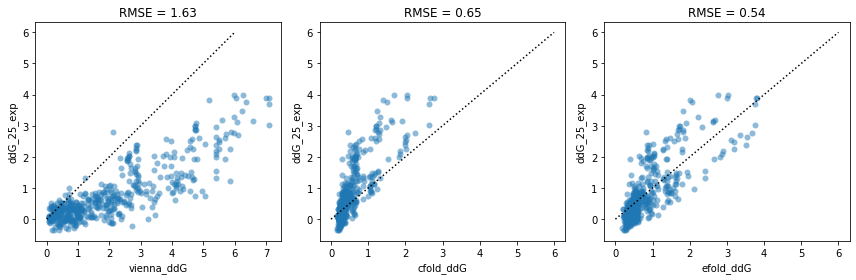

In [54]:
alpha=0.5
figure(figsize=(12,4))

def plot_diag(): plot([0,6],[0,6],linestyle=':',c='k')

tmp_df = df.loc[df['PUM_site']=='wt'][df['ddG_25_exp']<4]

subplot(1,3,1)

title('RMSE = %.2f' % np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['vienna_ddG']))))
sns.scatterplot(x='vienna_ddG',y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha)
plot_diag()

subplot(1,3,2)
title('RMSE = %.2f' % np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['cfold_ddG']))))
sns.scatterplot(x='cfold_ddG',y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha)
plot_diag()

subplot(1,3,3)
title('RMSE = %.2f' % np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['efold_ddG']))))
sns.scatterplot(x='efold_ddG',y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha)
plot_diag()

tight_layout()
savefig('PUM_analysis_vienna_contrafold.pdf',transparent=True, bbox_inches='tight')

/Users/hwayment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


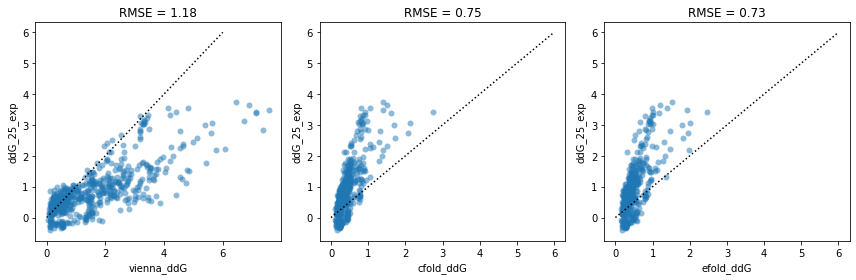

In [52]:
alpha=0.5
figure(figsize=(12,4))

def plot_diag(): plot([0,6],[0,6],linestyle=':',c='k')

tmp_df = df.loc[df['PUM_site']=='mut'][df['ddG_25_exp']<4]

subplot(1,3,1)

title('RMSE = %.2f' % np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['vienna_ddG']))))
sns.scatterplot(x='vienna_ddG',y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha)
plot_diag()

subplot(1,3,2)
title('RMSE = %.2f' % np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['cfold_ddG']))))
sns.scatterplot(x='cfold_ddG',y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha)
plot_diag()

subplot(1,3,3)
title('RMSE = %.2f' % np.sqrt(np.mean(np.square(tmp_df['ddG_25_exp']-tmp_df['efold_ddG']))))
sns.scatterplot(x='efold_ddG',y='ddG_25_exp',data=tmp_df,linewidth=0,alpha=alpha)
plot_diag()

tight_layout()
#savefig('PUM_analysis_vienna_contrafold.pdf',transparent=True, bbox_inches='tight')